pip install prophet  
pip install pandas
pip install xgboost
pip install openpyxl

In [1]:
import pandas as pd
import xgboost as xgb
from datetime import datetime, timedelta
from prophet import Prophet
import sklearn
import pyarrow

import calendar


/Users/jaimereinoso/DESARROLLO/CartonesAmericaProduccionXGBoostv3/venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


### **Carga de Archivos**
1.  Lee DemandaCOES.xlsx:  datos de consumo de energía del país
2.  Lee Festivos peru.xlsx:  datos de los dias feríados
3.  Lee datosCobre.xlsx:  datos de costo de cobre 

In [2]:
# DemandaCOES.xlsx

dfOriginal = pd.read_excel('DemandaCOES.xlsx',skiprows=3, header=0)
dfOriginal = dfOriginal[['FECHA','EJECUTADO']].copy()
dfOriginal['FECHA'] = pd.to_datetime(dfOriginal['FECHA'], dayfirst=True)
dfOriginal = dfOriginal.rename(columns={'FECHA':'ds','EJECUTADO':'y'})
dfOriginal['diaYYYYMMDD'] = dfOriginal['ds'].dt.strftime('%Y-%m-%d')
dfOriginal['diaYYYYMMDD'] = pd.to_datetime(dfOriginal['diaYYYYMMDD'])

dfFeriados = pd.read_excel('Festivos peru.xlsx')
dfFeriados = dfFeriados[['diaYYYYMMDD','festivo']].copy()

dfCobre = pd.read_excel('datosCobre.xlsx')
dfCobre = dfCobre[['fecha','valor']]
dfCobre['fecha'] = pd.to_datetime(dfCobre['fecha'])
dfCobre.rename(columns={'fecha': 'diaYYYYMMDD', 'valor':'cobre'}, inplace=True)
# NOTA:  el cobre trae el valor del dia anterior, asi que no hay lio.

comentario = " xgboot fest y max manana y cobre"


* dfOriginal ->  ds: datetime, y:float, diaYYYYMMDD datetime
* dfFeriados ->  diaYYYYMMDD:datetime, festivo:int
* dfCobre ->     diaYYYYMMDD:datetime, cobre:float

ahora unimos cobre a dfbase

In [3]:
dfbase = dfOriginal.copy()

# ahora metemos el valor del cobre en dfOriginal
dfbase = dfbase.merge(dfCobre, on=['diaYYYYMMDD'], how='left')

# # ahora metemos los festivos
dfbase = dfbase.merge(dfFeriados, on=['diaYYYYMMDD'], how='left')
dfbase['festivo'] = dfbase['festivo'].fillna(0)

# quitamos los nulos
dfbase = dfbase.dropna()



Vamos a entrenar un modelo con los datos de un año, desde el 30 de junio del 2022 hasta el 30 de junio del 2023 a las 2pm.   Eso será el entrenamiento

In [4]:
def crea_features(dfInput):

    # crea el Yi-1, Yi-2, ....
    lista_lags = []
    for i in range(1,30*48):
        new_df = pd.DataFrame()
        new_df['lag_' + str(i)] = dfInput['y'].shift(i)
        lista_lags.append(new_df)

    df_lg = pd.concat(lista_lags, axis=1)


    # # promedios rodantes por dia (48 medias horas)
    # # crea el  promedio de Yi-1, Yi-2, Yi-3 ... Yi-48 como rolling_day_1
    # #                      Yi-2, Yi-3, Yi-4 .... Yi-48 como rolling_day_2
    # # rolling_day_1 .. roling_day_30

    lista_rolling = []
    for i in range(1,31):
        new_df = pd.DataFrame()
        new_df['rolling_day_' + str(i)] = dfInput['y'].shift(i).rolling(window=48).mean()  # colocar 48
        lista_rolling.append(new_df)

    df_r = pd.concat(lista_rolling, axis=1)

    # # promedios rodantes de la semana (48*7), ultimas 25 semanas
    # # rolling_week_1 .. rolling_week_24
    lista_rolling_week = []
    for i in range(1,25):
        new_df = pd.DataFrame()
        new_df['rolling_week_' + str(i)] = dfInput['y'].shift(i).rolling(window=48*7).mean()
        lista_rolling_week.append(new_df)

    df_w = pd.concat(lista_rolling_week, axis=1)

    # # # ahora la media del mes (48*30), ultimos 12 meses
    # # rolling_month_1 .. rolling_month_12

    lista_rolling_month = []
    for i in range(1,13):
        new_df = pd.DataFrame()
        new_df['rolling_month_' + str(i)] = dfInput['y'].shift(i).rolling(window=48*30).mean()
        lista_rolling_month.append(new_df)

    df_m = pd.concat(lista_rolling_month, axis=1)

    # # # ahora la max de la mañana del mes (8), ultimos 30 dias
    # # rolling_morning_1 .. rolling_morning_30

    lista_rolling_morning = []
    for i in range(1,30):
        new_df = pd.DataFrame()
        new_df['rolling_morning_' + str(i)] = dfInput['y'].shift(i).rolling(window=8).max()
        lista_rolling_morning.append(new_df)

    df_m2 = pd.concat(lista_rolling_morning, axis=1)

    # # ahora los ultimos 30 dias del precio del cobre (30 * 48 medias horas que tiene un dia)
    lista_cobre = []
    for i in range(1,30*48):
        new_df = pd.DataFrame()
        new_df['cobre_' + str(i)] = dfInput['cobre'].shift(i)  # se toma el dato de hace 48 medias horas atras
        lista_cobre.append(new_df)

    df_cobre = pd.concat(lista_cobre, axis=1)


    # # -------


    df_n = pd.concat([dfInput, df_lg, df_r, df_w, df_m, df_m2, df_cobre], axis=1)

    # df_n['diaYYYYMMDD'] = df_n['ds'].dt.strftime('%Y-%m-%d')
    # df_n['diaYYYYMMDD'] = pd.to_datetime(df_n['diaYYYYMMDD'], format='%Y-%m-%d')
    df_n['ano'] = df_n['ds'].dt.year
    df_n['mes'] = df_n['ds'].dt.month
    df_n['diaDelMes'] = df_n['ds'].dt.day
    df_n['diaDeLaSemana'] = df_n['ds'].dt.dayofweek
    df_n['Trimestre'] = df_n['ds'].dt.quarter
    df_n['semana'] = df_n['ds'].dt.isocalendar().week  # Obtener el número de semana del año
    df_n['hora'] = df_n['ds'].dt.hour


    return df_n

In [5]:

dfbase = crea_features(dfbase)

# dfbase = dfbase.dropna()
dfbase = dfbase.reset_index(drop=True)


In [6]:
# debemos generar predicciones del siguiente dia cuando cambie el dia
# y para eso vamos a usar Prophet de facebook.     este requiere
# que las columnas se llamen ds y "y" en vez de fecha y valor

dfCobre.rename(columns={"diaYYYYMMDD": "ds", "cobre": "y"}, inplace=True)

# esta es la fechahora actual (2pm de un dia L a S)
f = dfbase.iloc[-1]['ds']

# obtenemos el ultimo dia del mes en que está f y le sumamos 30 minutos
f_max = calendar.monthrange(f.year, f.month)[1]
f_max = datetime(f.year, f.month, f_max)
f_max = f_max + timedelta(days=1)

# esta varialbe nos ayuda a detectar un nuevo dia, es f pero solo YYYY-MM-DD
fDia_actual = f.date()

obtenemos las predicciones del cobre con facebook prophet

In [7]:
# lo primero es calcular las predicicones del cobre usando facebook prophet

dfCobreNuevo = dfCobre[(dfCobre['ds'] > f - pd.DateOffset(years=1)) 
                        & (dfCobre['ds'] <= f)].copy()
dfCobreNuevo = dfCobreNuevo.reset_index(drop=True)

# Crear un modelo Prophet
model = Prophet()

# Ajustar el modelo a los datos
model.fit(dfCobre) 

# Crear un DataFrame con las fechas futuras que deseas predecir
if f.month < 12:
    primerDiaMesSiguiente = datetime(f.year, f.month + 1, 1)
else:
    primerDiaMesSiguiente = datetime(f.year + 1, 1, 1)

ultimoDiaMesActual = primerDiaMesSiguiente - timedelta(days=1)
cuantosDiasFaltan = (ultimoDiaMesActual - f).days + 1

# se genera predicción desde el dia de hoy hasta el final del mes
print('f:', f)
print('ultimoDiaMesActual:', ultimoDiaMesActual)
print('cuantosDiasFaltan:', cuantosDiasFaltan)

future = model.make_future_dataframe(periods=cuantosDiasFaltan)  
CobreForecast = model.predict(future)

14:36:00 - cmdstanpy - INFO - Chain [1] start processing
14:36:00 - cmdstanpy - INFO - Chain [1] done processing


f: 2024-03-07 14:30:00
ultimoDiaMesActual: 2024-03-31 00:00:00
cuantosDiasFaltan: 24


Ahora vamos a entrenar el modelo actual

In [8]:
# df es nuevamente creado con 1 año hacia atras de datos hasta el mes en que vamos
df = dfbase[(dfbase['ds'] > f - pd.DateOffset(years=1)) &
        (dfbase['ds'] <= f)].copy()

df = df.reset_index(drop=True)

In [9]:


# Entrenar el modelo XGBoost
params = {
    'objective': 'reg:squarederror',  # Para problemas de regresión
    'n_estimators': 100,
    'max_depth': 3,
    'learning_rate': 0.05,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'random_state': 42,
    'device': 'cuda',
    'tree_method':'hist'
}
model = xgb.XGBRegressor(**params)

# no es necesario quitar el cobre_i, pues ya se puso el valor del dia anterior.
X_train = df.drop(['y', 'ds','cobre', 'diaYYYYMMDD'], axis=1)
y_train = df['y']  # estos son valores reales

model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device='cuda', early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

Ahora vamos a hacer un ciclo desde la fecha actual hasta el primer dia del siguiente mes haciendo las predicciones de "y"

In [10]:

# Extraer el mes actual
ano_actual = f.year
mes_actual = f.month

if mes_actual == 12:
    siguiente_ano = ano_actual + 1
    siguiente_mes = 1
else:
    siguiente_ano = ano_actual
    siguiente_mes = mes_actual + 1

# Crear una nueva fecha para el primer día del mes siguiente a las 00:0:00
primer_dia_siguiente_mes = datetime(siguiente_ano, siguiente_mes, 1, 0, 0, 0)

f_prediccion = f

while f_prediccion <= primer_dia_siguiente_mes:

    print('f_prediccion:', f_prediccion)

    nueva_fila = []

    # adicionamos el nuevo ds
    nueva_fila.append(f_prediccion)

    # adicionamos el nuevo y que por ahora es cero.  se calcula al final
    nuevo_y = 0 
    nueva_fila.append(nuevo_y)

    #insertamos el diaYYYYMMDD
    f_prediccionYYYYMMDD = f_prediccion.strftime("%Y-%m-%d")
    f_prediccionYYYYMMDD = pd.to_datetime(f_prediccionYYYYMMDD)
    nueva_fila.append(f_prediccionYYYYMMDD)

    # y ahora vamos a insertar el valor del cobre, que debe ser el predicho
    # OJO:  la consulta a CobreForcast es por dia y no por dia+horas
    fila_correspondiente = CobreForecast[CobreForecast['ds'] == f_prediccionYYYYMMDD - pd.Timedelta(days=1)]
    nuevo_cobre = fila_correspondiente['yhat'].values[0]
    nueva_fila.append(nuevo_cobre)

    # ahora adicionamos si es un dia festivo o no
    # si la fecha es un dia festivo, se debe incluir un 1, o de lo contrario un 0
    aparece_en_columna_f = (dfFeriados['diaYYYYMMDD'] == f_prediccion.strftime('%Y-%m-%d')).any()
    if aparece_en_columna_f:
        nueva_fila.append(1)
    else:
        nueva_fila.append(0)

    # ---------  FILAS LAGS_i  ---------------
    # creamos todos los demas lags.  El primero le copiamos "y" anterior
    filaLags = df.iloc[-1]['lag_1':'lag_1439'].copy()
    filaLags = filaLags.shift(1)
    filaLags = filaLags.tolist()
    filaLags[0]=df.iloc[-1]['y']

    # ---------  FILAS ROLLING_DAY_i 1:30 ---------------
    # promedios rodantes del dia (48 medias horas), un dia

    # se hace shift y la primera se calcula con la media de las ultimas 48 medias horas = 1 dia
    columnas_seleccionadas = [col for col in df.columns if col.startswith('rolling_day_')]

    # se hace shift y la primera se calcula con la media de las ultimas 24 y
    filaRDays = df.iloc[-1][columnas_seleccionadas].copy()
    filaRDays = filaRDays.shift(1)
    filaRDays = filaRDays.tolist()
    filaRDays[0]=df['y'].tail(48).mean()

    # ---------  FILAS ROLLING_WEEK_i  ---------------
    # promedios rodantes de la semana (48 medias horas * 7 dias),

    columnas_seleccionadas = [col for col in df.columns if col.startswith('rolling_week_')]

    # se hace shift y la primera se calcula con la media de las ultimas 24 y
    filaRWeeks = df.iloc[-1][columnas_seleccionadas].copy()
    filaRWeeks = filaRWeeks.shift(1)
    filaRWeeks = filaRWeeks.tolist()
    filaRWeeks[0]=df['y'].tail(48*7).mean()

    # ---------  FILAS ROLLING_MONTH_i  ---------------
    # promedios rodantes de la semana (48 medias horas * 30 dias),

    columnas_seleccionadas = [col for col in df.columns if col.startswith('rolling_month_')]

    # se hace shift y la primera se calcula con la media de las ultimas 24 y
    filaRMonths = df.iloc[-1][columnas_seleccionadas].copy()
    filaRMonths = filaRMonths.shift(1)
    filaRMonths = filaRMonths.tolist()
    filaRMonths[0]=df['y'].tail(48*30).mean()

    # ---------  FILAS ROLLING_MORNING_i  ---------------
    # maximos 8 horas en la mañana 6am-2pm del dia (8 medias horas * 30 dias),

    columnas_seleccionadas = [col for col in df.columns if col.startswith('rolling_morning_')]

    # se hace shift y la primera se calcula con la media de las ultimas 24 y
    filaRMornings = df.iloc[-1][columnas_seleccionadas].copy()
    filaRMornings = filaRMornings.shift(1)
    filaRMornings = filaRMornings.tolist()
    filaRMornings[0]=df['y'].tail(8).max()

    # ---------  FILAS COBRE_i  ---------------

            # creamos todos los demas lags.  El primero le copiamos "y" anterior
    filaCobre = df.iloc[-1]['cobre_1':'cobre_1439'].copy()
    filaCobre = filaCobre.shift(1)
    filaCobre = filaCobre.tolist()
    filaCobre[0]=df.iloc[-1]['cobre']


    # ------------- features de ds para serie de tiempos -------------------

    filaFeaturesDs = []
    # diaYYYYMMDD

    print('f:',f,' f_prediccion:', f_prediccion)
    # filaFeaturesDs.append(f_prediccion.strftime('%Y-%m-%d'))
    # ano
    filaFeaturesDs.append(f_prediccion.year)
    # mes
    filaFeaturesDs.append(f_prediccion.month)
    # diaDelMes
    filaFeaturesDs.append(f_prediccion.day)
    # diaDeLaSemana
    filaFeaturesDs.append(f_prediccion.dayofweek)
    # trimestre
    filaFeaturesDs.append(f_prediccion.quarter)
    # semana
    filaFeaturesDs.append(f_prediccion.isocalendar().week)
    # hora
    filaFeaturesDs.append(f_prediccion.hour)

    

    # ---------  END  -------------------------------

    # esta es la nueva fila que vamos a predecir
    nueva_fila = nueva_fila + filaLags + filaRDays + filaRWeeks + filaRMonths + filaRMornings + filaCobre + filaFeaturesDs

    #  insertamos la nueva fila en el dataframe
    df.loc[len(df)] = nueva_fila

    # tomamos la ultima fila, ahora si como un dataframe
    dfTest = df.tail(1).copy()

    # # generamos la nueva predicción creando la fila que vamos a predecir
    X_test = dfTest.drop(columns=['y', 'ds', 'cobre','diaYYYYMMDD'])

    nuevo_y = model.predict(X_test)

    # Asignamos el valor obtenido a la columna "y" de la última fila de df
    df.at[df.index[-1], 'y'] = nuevo_y[0]

    # Nos movemos 30 minutos más adelante
    f_prediccion = f_prediccion + pd.DateOffset(minutes=30)







f_prediccion: 2024-03-07 14:30:00
f: 2024-03-07 14:30:00  f_prediccion: 2024-03-07 14:30:00
f_prediccion: 2024-03-07 15:00:00
f: 2024-03-07 14:30:00  f_prediccion: 2024-03-07 15:00:00
f_prediccion: 2024-03-07 15:30:00
f: 2024-03-07 14:30:00  f_prediccion: 2024-03-07 15:30:00
f_prediccion: 2024-03-07 16:00:00
f: 2024-03-07 14:30:00  f_prediccion: 2024-03-07 16:00:00
f_prediccion: 2024-03-07 16:30:00
f: 2024-03-07 14:30:00  f_prediccion: 2024-03-07 16:30:00
f_prediccion: 2024-03-07 17:00:00
f: 2024-03-07 14:30:00  f_prediccion: 2024-03-07 17:00:00
f_prediccion: 2024-03-07 17:30:00
f: 2024-03-07 14:30:00  f_prediccion: 2024-03-07 17:30:00
f_prediccion: 2024-03-07 18:00:00
f: 2024-03-07 14:30:00  f_prediccion: 2024-03-07 18:00:00
f_prediccion: 2024-03-07 18:30:00
f: 2024-03-07 14:30:00  f_prediccion: 2024-03-07 18:30:00
f_prediccion: 2024-03-07 19:00:00
f: 2024-03-07 14:30:00  f_prediccion: 2024-03-07 19:00:00
f_prediccion: 2024-03-07 19:30:00
f: 2024-03-07 14:30:00  f_prediccion: 2024-03-

### **Definiciones:**
* **dfbase:**  es la data original tomada desde la página de CAME con un año de historia y columnas **ds** y **y**
* **df:**      es una copia de dfbase asegurando 1 año de anticipación EXACTAMENTE y que tiene otras variables de lag e históricas.  Posteriormente a este dataframe se le adicionan todas las filas que falten para terminar el mes y en **y** se coloca el valor predicho
* **dfEsteMes:** solo tiene este mes de **df**, con la info tanto real como predicha
* **dfReal:**  es la parde de **dfEsteMes** que contiene sólo la real, y no incluye las predicciones
* **forecast:** es la prde de **dfEsteMes** que NO contiene la parte real, pero si las predicciones

## ALERTA: los dataframes luego deben ser recortados cuando corresponda para que solo tomen los datos entre las 5y 11pm de Lunes a Sábado.

In [11]:
primer_dia_mes_actual = datetime(ano_actual, mes_actual, 1, 0, 30, 0)

In [12]:
# creamos los dataframes con los datos completos del mes (dfEsteMes), solo lo real (dfReal) o solo lo predicho (forecast)
# OJO, en este punto tiene los datos de todas las horas y no solo de 5 a 11pm de L a S.

dfEsteMes = df[(df['ds'] <= primer_dia_siguiente_mes) & 
              (df['ds'] >= primer_dia_mes_actual)].copy()

# OJO, la fila con hora 17:30, mide lo consumido entre las 5:00pm y las 5:30pm.   
dfEsteMesRango = dfEsteMes[(dfEsteMes['ds'].dt.weekday < 6) &
                        (dfEsteMes['ds'].dt.time >= pd.to_datetime('17:30').time()) & 
                        (dfEsteMes['ds'].dt.time < pd.to_datetime('23:30').time())
                           ]

dfReal = df[(df['ds'] < primer_dia_siguiente_mes) & 
               (df['ds'] >= primer_dia_mes_actual)].copy()

dfRealRango = dfReal[(dfReal['ds'].dt.weekday < 6) & 
                     (dfReal['ds'].dt.time >= pd.to_datetime('17:30').time()) & 
                     (dfReal['ds'].dt.time < pd.to_datetime('23:30').time())]

forecast = df[(df['ds'] <= primer_dia_siguiente_mes) & 
              (df['ds'] >= f)].copy()

forecastRango = forecast[(forecast['ds'].dt.weekday < 6) &
                         (forecast['ds'].dt.time >= pd.to_datetime('17:30').time()) & 
                         (forecast['ds'].dt.time < pd.to_datetime('23:30').time())]


pico_predicho_idx = dfEsteMesRango['y'].idxmax()
pico_predicho_y = dfEsteMesRango['y'].max()
pico_predicho_ds = dfEsteMesRango.loc[pico_predicho_idx,'ds'] 
pico_predicho_yyyymmdd = pico_predicho_ds.strftime('%Y-%m-%d')

In [13]:
print(pico_predicho_y, pico_predicho_ds)

7640.77741 2024-03-04 19:00:00


In [14]:
# determinamos el pico maximo a tolerar, y se lee de forecastRango, o sea de los dias que faltan, 
# y solo tomando en cuenta el horario entre las 5 y 11pm, de lunes a sábado

c = 0.005
pico_corte = pico_predicho_y*(1-c)
dfDiasAEliminar = forecastRango[forecastRango['y']>pico_corte].copy()

dfDiasAEliminar['fecha'] = dfDiasAEliminar['ds'].dt.strftime('%Y-%m-%d')
dfDiasAEliminarFinal = dfDiasAEliminar['fecha'].drop_duplicates()
dfDiasAEliminarFinal = dfDiasAEliminarFinal[dfDiasAEliminarFinal>=f.strftime('%Y-%m-%d')]

In [15]:
forecastRango.to_excel('forecastRango.xlsx')
dfDiasAEliminarFinal.to_excel('dfDiasAEliminarFinal.xlsx')

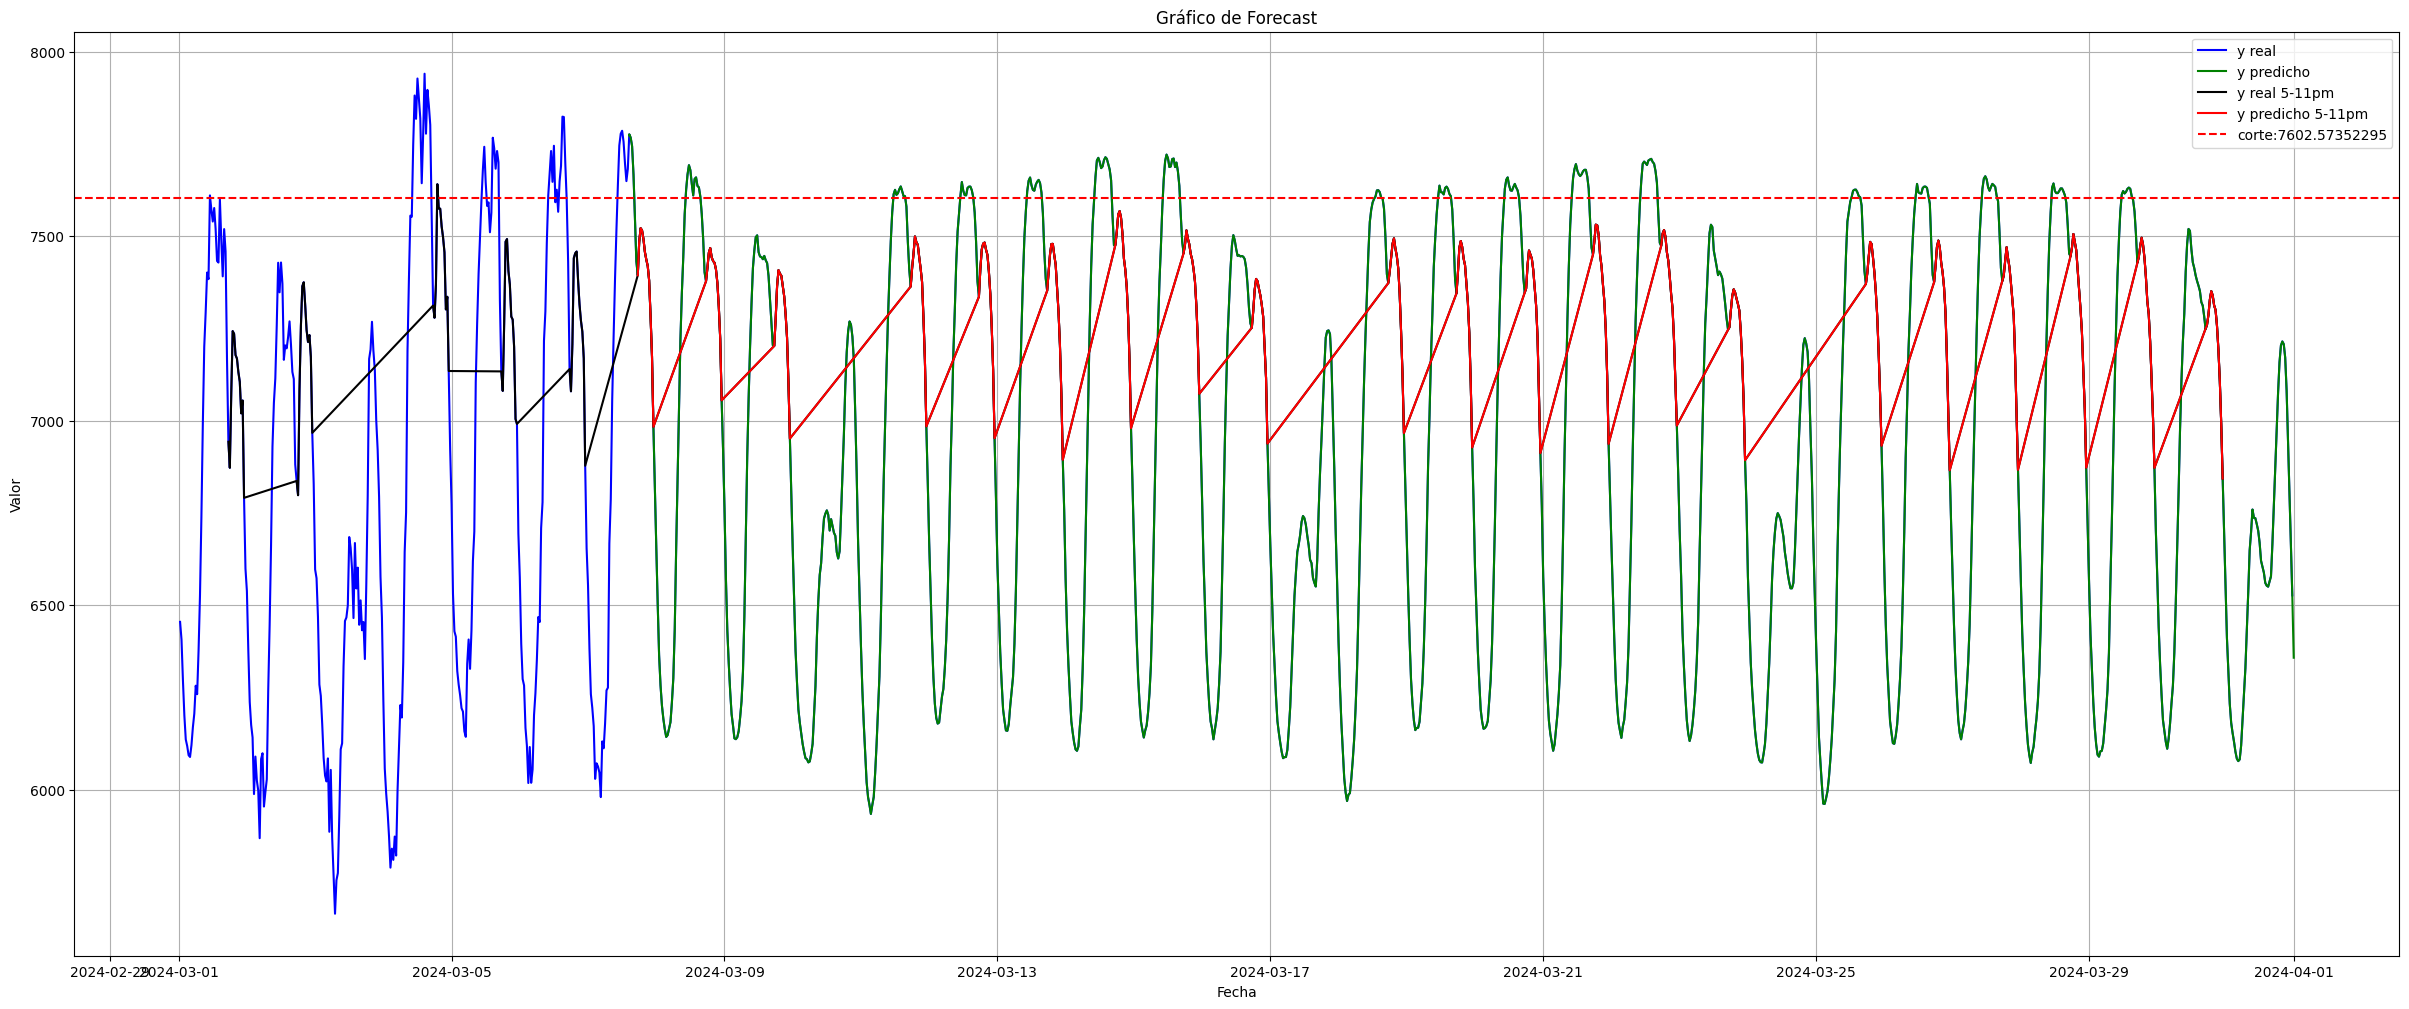

Series([], Name: fecha, dtype: object)


In [16]:
import matplotlib.pyplot as plt

# Crea el gráfico
plt.figure(figsize=(30, 12))  # Tamaño del gráfico
# Grafica la columna "ds" en el eje x, "y" en el eje y (línea azul) 
plt.plot(dfReal['ds'], dfReal['y'], label='y real', color='blue')
plt.plot(forecast['ds'], forecast['y'], label='y predicho', color='green')
plt.plot(dfRealRango['ds'], dfRealRango['y'], label='y real 5-11pm', color='black')
plt.plot(forecastRango['ds'], forecastRango['y'], label='y predicho 5-11pm', color='red')
# Agrega la línea horizontal en la altura de "pico_corte"
plt.axhline(y=pico_corte, color='red', linestyle='--', label=f'corte:{pico_corte}')

# Personaliza el gráfico
plt.title('Gráfico de Forecast')
plt.xlabel('Fecha')
plt.ylabel('Valor')
plt.legend()  # Muestra la leyenda

# Muestra el gráfico
plt.grid(True)

# Guarda la imagen generada por Matplotlib en un archivo temporal
temp_img_path = 'temp_plot.png'
plt.savefig(temp_img_path)
plt.show()

print(dfDiasAEliminarFinal)

In [17]:
# Obtenemos los picos por dia, tomando en cuenta solo rango
max_values_per_day_rango = dfEsteMesRango.groupby(dfEsteMesRango['ds'].dt.date)['y'].max().reset_index()
max_values_per_day_rango['ds'] = pd.to_datetime(max_values_per_day_rango['ds'], dayfirst=True)

# pico_predicho_y y pico_predicho_ds tienen el valor máximo del mes en horario 5-11pm de L a S.


import matplotlib.pyplot as plt

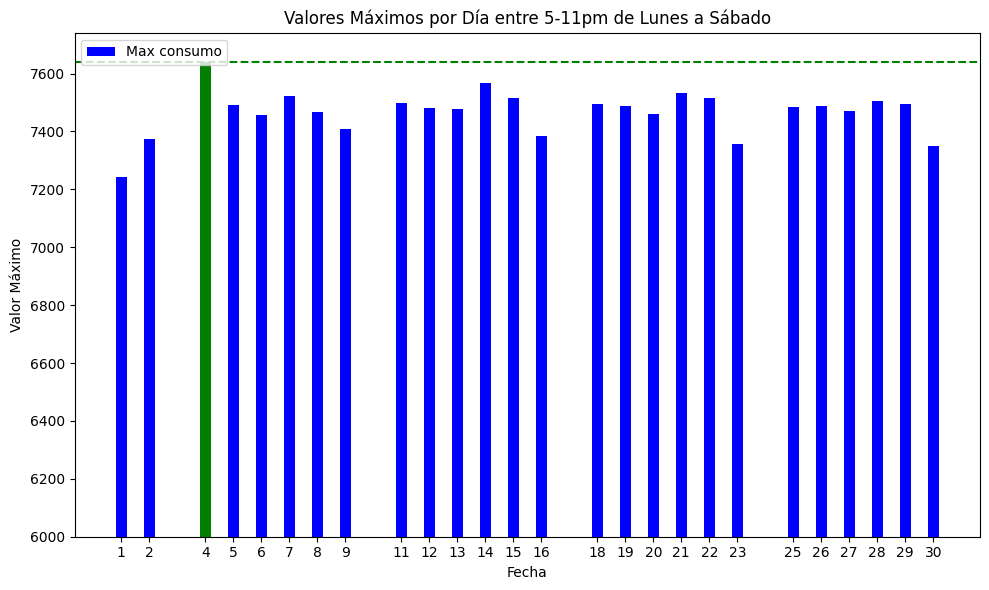

In [18]:
# Crear una gráfica de barras
plt.figure(figsize=(10, 6))  # Establecer el tamaño de la gráfica

# Obtener las fechas (días) y los valores máximos de  'Y'
fechas = max_values_per_day_rango['ds']
max_y = max_values_per_day_rango['y']

# # Obtener el día del mes
fechas = pd.to_datetime(fechas)
dias_mes = fechas.dt.day
dia_max = pico_predicho_ds.day


# Configurar las barras de y
colores_barras = ['blue' if dia != dia_max else 'green' for dia in dias_mes]

plt.bar(dias_mes, max_y, width=0.4, label='Max consumo', align='center', color=colores_barras)
#Configurar el límite inferior del eje Y para que arranque desde 6,000
plt.ylim(6000, max(max_y ) + 100)  # Ajusta el límite superior según tus datos


# Configurar el eje x para que muestre las fechas de forma legible
plt.xticks(dias_mes)
plt.xlabel('Fecha')

# Etiquetas y leyenda
plt.ylabel('Valor Máximo')
plt.legend(loc='upper left')

# Título de la gráfica
plt.title('Valores Máximos por Día entre 5-11pm de Lunes a Sábado')


# Destacar el valor máximo global de 'YHAT' con otro color
plt.axhline(y=pico_predicho_y, color='green', linestyle='--', label=f'Max Global YHAT ({pico_predicho_y:.2f})')

# Mostrar la gráfica
plt.tight_layout()

# Guarda la imagen generada por Matplotlib en un archivo temporal
temp_img_path2 = 'temp_plot2.png'
plt.savefig(temp_img_path2)
plt.show()

# Generamos POWERPOINT

In [19]:
from pptx import Presentation
from pptx.util import Inches
from pptx.dml.color import RGBColor

# Cargar la presentación
prs = Presentation('Reportar Resultados Template.pptx')

# Seleccionar la diapositiva deseada (por ejemplo, la primera diapositiva)
slide = prs.slides[1]

# Recorrer todas las imágenes en la diapositiva
# for i, shape in enumerate(slide.shapes):
#     print(i, '-' , shape.name, '-', shape.shape_type)

# 0, 6 y 11 son imagenes.  el 9 es un grafico
# 0:  calendario
# 6:  icono de cartones america
# 9:  la x blanca en un circulo rojo
# 11: es la gráfica que queremos actualizar!! y es de tipo PICTURE 13

newImagePath = 'temp_plot.png'
slide.shapes.add_picture(newImagePath, Inches(0), Inches(2.37), Inches(7.24), Inches(3))

dfDiasAEliminarFinal = dfDiasAEliminarFinal.reset_index(drop=True)

table = slide.shapes.add_table(rows=dfDiasAEliminarFinal.size+1, cols=2, left=Inches(7.72), top=Inches(2.39), width=Inches(5), height=Inches(0.8)).table

# Agregar contenido a la tabla (opcional)
# Puedes acceder a las celdas de la tabla y agregar contenido a cada celda
table.cell(0, 0).text = "id"
table.cell(0, 1).text = "Día"

i = 1
for dia in dfDiasAEliminarFinal:
    table.cell(i, 0).text = str(i)
    table.cell(i, 1).text = dia
    i += 1

# Seleccionar la diapositiva tercera
slide = prs.slides[2]
newImagePath = 'temp_plot2.png'
slide.shapes.add_picture(newImagePath, Inches(0), Inches(2.37), Inches(7.24), Inches(3))

text_box = slide.shapes.add_textbox(Inches(7.72), Inches(2.39), Inches(5), Inches(0.8))

# Agrega un párrafo de texto al cuadro de texto
tf = text_box.text_frame
p = tf.add_paragraph()
p.text = pico_predicho_yyyymmdd

# Ajusta el formato del texto
p.font.size = Inches(0.5)
p.font.bold = True
color = RGBColor(0, 128, 0)  # Rojo (255, 0, 0) en formato RGB
p.font.color.rgb = color

prs.save('Reportar Resultados.pptx')

In [20]:
dfDiasAEliminarFinal

Series([], Name: fecha, dtype: object)